In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow import keras 
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

In [140]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'AAPL'

In [141]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [142]:
type(data)

pandas.core.frame.DataFrame

In [143]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-25,43.540001,43.967499,43.487499,43.557499,41.932758,87493600
2019-02-26,43.427502,43.825001,43.292500,43.582500,41.956829,68280800
2019-02-27,43.302502,43.750000,43.182499,43.717499,42.086792,111341600
2019-02-28,43.580002,43.727501,43.230000,43.287498,41.672825,112861600
2019-03-01,43.570000,43.787498,43.222500,43.742500,42.110859,103544800


In [144]:
len(data)

1258

In [145]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-15,183.550003,184.490005,181.350006,183.860001,183.860001,65434500
2024-02-16,183.419998,184.850006,181.669998,182.309998,182.309998,49701400
2024-02-20,181.789993,182.429993,180.000000,181.559998,181.559998,53665600
2024-02-21,181.940002,182.889999,180.660004,182.320007,182.320007,41529700
2024-02-22,183.479996,184.960007,182.460007,184.369995,184.369995,52253700


In [146]:
opn = data[['Open']]

<Axes: xlabel='Date'>

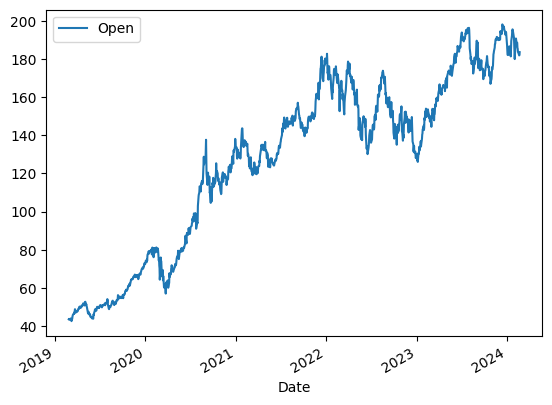

In [147]:
opn.plot()

In [148]:
ds = opn.values

In [149]:
ds

array([[ 43.54000092],
       [ 43.42750168],
       [ 43.30250168],
       ...,
       [181.78999329],
       [181.94000244],
       [183.47999573]])

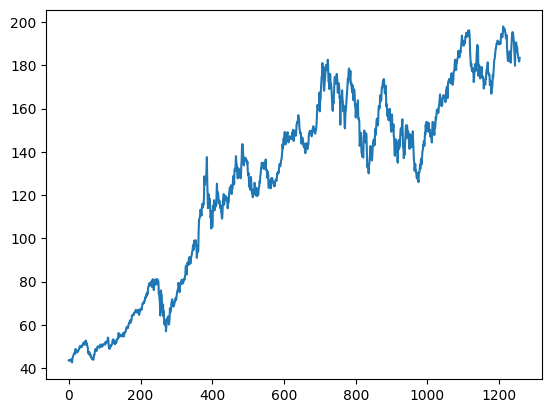

In [150]:
plt.plot(ds)

In [151]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [152]:
len(ds_scaled), len(ds)

(1258, 1258)

In [153]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [154]:
train_size,test_size

(880, 378)

In [155]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [156]:
len(ds_train),len(ds_test)

(880, 378)

In [157]:
print(ds_test)

[[0.81774317]
 [0.80095212]
 [0.80249616]
 [0.8118888 ]
 [0.82340455]
 [0.7628023 ]
 [0.76910706]
 [0.75739831]
 [0.73378793]
 [0.75379565]
 [0.73269427]
 [0.72207928]
 [0.72092123]
 [0.72626092]
 [0.75276629]
 [0.75476062]
 [0.72188619]
 [0.72098553]
 [0.69885488]
 [0.68663146]
 [0.71294384]
 [0.73829126]
 [0.70638189]
 [0.69872619]
 [0.68888317]
 [0.7086979 ]
 [0.67588778]
 [0.66598046]
 [0.63497166]
 [0.61522133]
 [0.65909673]
 [0.65292077]
 [0.66411473]
 [0.64307765]
 [0.62943898]
 [0.62609361]
 [0.62114   ]
 [0.59450593]
 [0.65446471]
 [0.63362072]
 [0.66205611]
 [0.63760936]
 [0.64616573]
 [0.64520067]
 [0.67299279]
 [0.69164946]
 [0.69724655]
 [0.67865417]
 [0.67949044]
 [0.7113999 ]
 [0.72375192]
 [0.68431545]
 [0.63998967]
 [0.64018266]
 [0.6081446 ]
 [0.62937468]
 [0.61708696]
 [0.63471437]
 [0.66417913]
 [0.68444414]
 [0.70535253]
 [0.6854735 ]
 [0.66810338]
 [0.70593151]
 [0.69209985]
 [0.67904015]
 [0.68753212]
 [0.68019811]
 [0.6598044 ]
 [0.65433601]
 [0.63574363]
 [0.67

In [158]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [159]:
def create_ds1(dataset,step):
    Xtest, Ytest = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtest.append(a)
        Ytest.append(dataset[i + step, 0])
    return np.array(Xtest), np.array(Ytest)



In [160]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
# X_test, y_test = create_ds1(ds_test,time_stamp)

In [161]:
X_train.shape,y_train.shape

((779, 100), (779,))

In [162]:
#Taking 100 days price as one record for training
time_stamp = 100
# X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds1(ds_test,time_stamp)


In [163]:
X_test.shape, y_test.shape

((277, 100), (277,))

In [164]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)



In [165]:

# Plotting the MSE errors

window_size = 20
N = ds_train.size
std_avg_predictions = []
mse_errors = []

for pred_idx in range(window_size, N):
    std_avg_predictions.append(np.mean(ds_train[pred_idx - window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1] - ds_train[pred_idx]) ** 2)

mse = np.mean(mse_errors)
# print('MSE error for standard averaging: %.5f' % mse)


In [166]:
all_mid_data = np.concatenate([ds_train,ds_test],axis=0)
print(all_mid_data)

[[0.00617601]
 [0.00545226]
 [0.00464809]
 ...
 [0.89558665]
 [0.89655171]
 [0.90645903]]


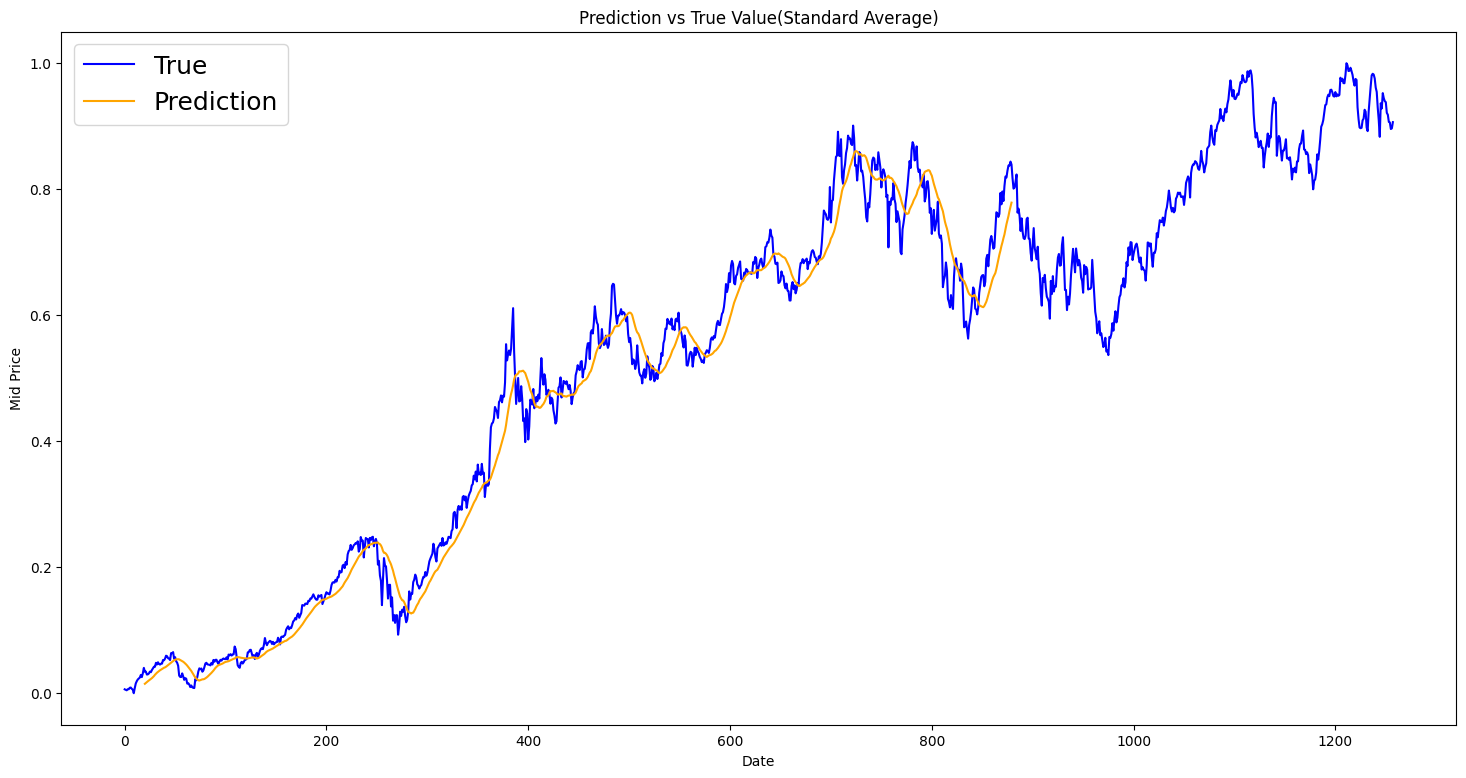

In [167]:

plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
# plt.xticks(range(0,data.shape[0],50),data['Date'].loc[::50],rotation=45)
plt.title('Prediction vs True Value(Standard Average)')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


In [168]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [169]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
13/13 [==============================] - 30s 736ms/step - loss: 0.0621 - val_loss: 0.0632
Epoch 2/100
13/13 [==============================] - 3s 259ms/step - loss: 0.0104 - val_loss: 0.0021
Epoch 3/100
13/13 [==============================] - 3s 255ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 4/100
13/13 [==============================] - 3s 251ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 5/100
13/13 [==============================] - 3s 249ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 6/100
13/13 [==============================] - 3s 263ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 7/100
13/13 [==============================] - 3s 251ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 8/100
13/13 [==============================] - 3s 246ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 9/100
13/13 [==============================] - 3s 249ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 10/100
13/13 [==============================] - 3s 251ms/step - loss: 0.0019 - val_l

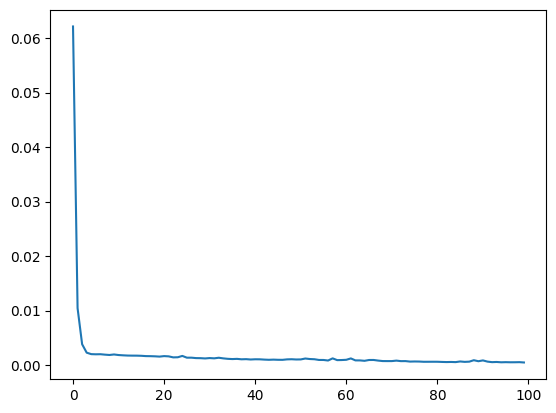

In [170]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [171]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 1s 77ms/step


In [172]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

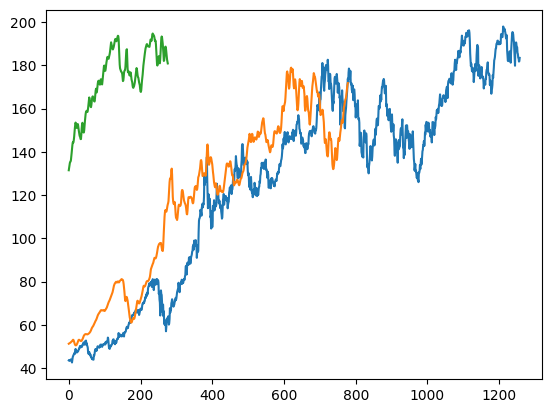

In [173]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [174]:
type(train_predict)

numpy.ndarray

In [175]:
test = np.vstack((train_predict,test_predict))

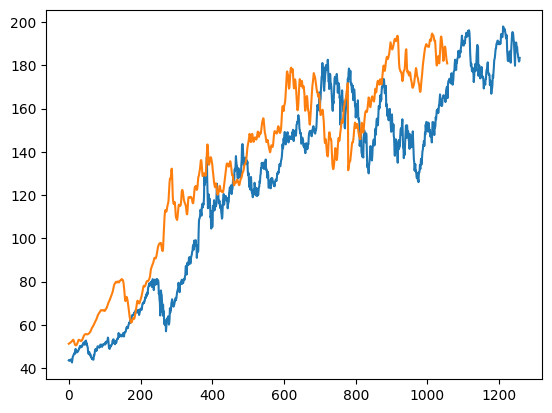

In [176]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [177]:
len(ds_test)

378

In [178]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [179]:
fut_inp = fut_inp.reshape(1,-1)

In [180]:
tmp_inp = list(fut_inp)

In [181]:
fut_inp.shape

(1, 108)

In [182]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [183]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=107
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        # fut_inp = fut_inp.reshape((1, n_steps, 1))
        fut_inp = fut_inp[:n_steps].reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.8888111710548401], [0.8876110911369324], [0.8837119936943054], [0.8786519169807434], [0.8733599781990051], [0.8681601881980896], [0.8630965352058411], [0.8581514954566956], [0.8533180356025696], [0.8486045002937317], [0.8440208435058594], [0.8395702242851257], [0.8352490067481995], [0.8310495018959045], [0.8269630074501038], [0.8229819536209106], [0.8191009163856506], [0.8153174519538879], [0.8116311430931091], [0.8080434203147888], [0.8045566082000732], [0.8011726140975952], [0.797893762588501], [0.7947206497192383], [0.7916532754898071], [0.788689911365509], [0.7858278751373291], [0.7830631732940674], [0.7803921699523926], [0.7778094410896301]]


In [184]:
len(ds_scaled)

1258

In [185]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

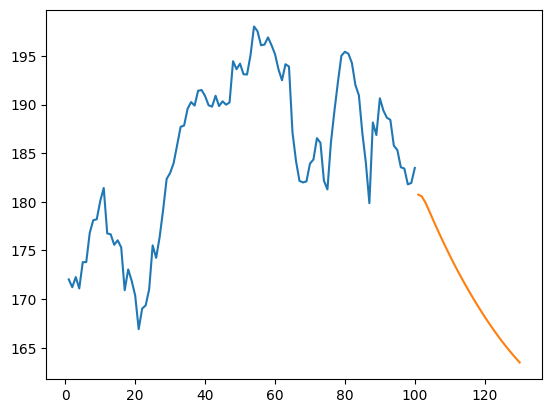

In [186]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1158:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [187]:
ds_new = ds_scaled.tolist()

In [188]:
len(ds_new)

1258

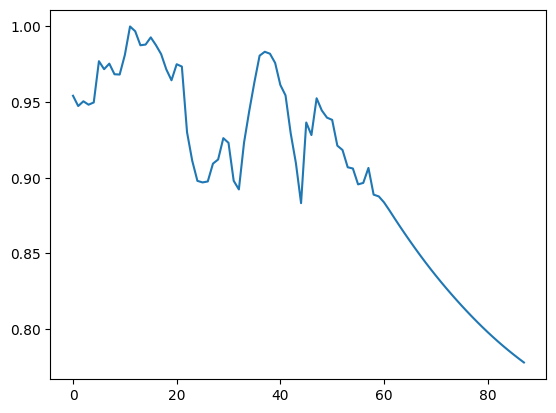

In [189]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [190]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

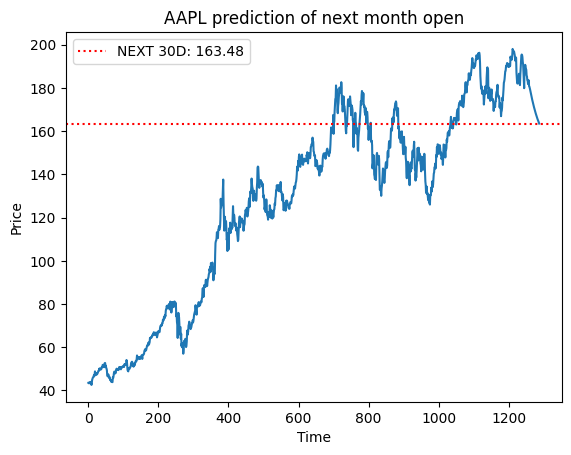

In [191]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

